In [ ]:
!git pull https://github.com/Francesco215/Quantum-diffusion.git

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


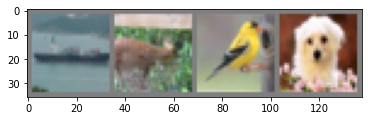

ship  deer  bird  dog  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
n_bits = 8

In [5]:
from src.unet import Unet

model = Unet(
    dim = 32,
    channels = 3,
    dim_mults = (1, 2, 4, 8),
    bits = n_bits
)

In [6]:
from src.BitDiffusion import BitDiffusion

diffusion = BitDiffusion(model, image_size = 32)

In [7]:
img = torch.rand((4, 3, 32, 32))

In [8]:
from src.utils import *
decimal_to_qubits(img, n_bits).shape

torch.Size([4, 24, 32, 32])

In [ ]:
# Train the model

optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-3)

from tqdm.auto import tqdm

for epoch in range(10):
    for i, (images, _) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        loss = diffusion(images)
        loss.backward()
        optimizer.step()

        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1}] loss: {loss.item():.3f}')

In [ ]:
!pip install pytorch-fid
from pytorch_fid import fid_score
fid_score()
!python -m pytorch_fid "path/to/dataset1" "path/to/dataset2"